# NLP: Disaster Tweets

This Kaggle challenge is to classify a given Tweet as referencing a disaster
or not referencing a disaster. That is to say, we solve a binary
classification problem on a natural language dataset.

One pecularity we see is that the language is very natural, so to say.
Nonstandard written English is expected and syntax will be bent by the inclusion of
hashtags and ats. Our goal is to classify the data entirely on the text.
While some conclusion can be drawn from the keyword label, I feel this problem is
best approached for educational purposes as a general binary classification on text.
Here we attempt to solve this problem by a few different neural network
architectures on text.

We try a bidirection RNN architecture, a convolutional neural network,
and lastly we use a massive pretrained model BERT.

We begin with importing modules and peaking at the dataset.

## Import statements

For the import statements, I feel it is best to do the high level imports.
The interpreter is smart enough to load only what it needs to when a particular
module method is called, and I find an excessive number of very particular imports
can cause a couple issues. First, it creates a higher chance of name collisions.
Second, when developing an application, a function can be imported and then eventually
discarded and after it is discarded, one may forget to remove the import statement.
Fewer import statements are cleaner and more precise as to what exactly the dependencies
are for your application. Frankly, I find nothing more unaesthetic than obscenly long
header to a module.

In [1]:
import os
import sys
import logging
import itertools
import re

import pandas as pd
import numpy as np
import sklearn.metrics
import sklearn.preprocessing
import nltk

import tensorflow as tf
import tensorflow_hub as hub
import bert
import bert.tokenization

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.offline
import wordcloud

## Logging and formatting

While the Pandas warning for chained assignments is important to remind
a coder that DataFrames pass references with assignment unless *copy* is called,
at one point I do want to simply work on the slices and mutate them without
unnecessarily duplicated the data. Thus it is turned off, and it probably be off 
by default.

Here I make a logging object for no better reason than its probably good
practice and should be templated code that appears at the top of any module.

Here is another bit of template code where we log
the package versions to console.

In [2]:
plotly.offline.init_notebook_mode(connected=True)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 160

log = logging.getLogger(name=__name__)
log.setLevel(logging.INFO)
logging.captureWarnings(True)
formatter = logging.Formatter(
    '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.INFO)

stream_handler.setFormatter(formatter)
log.addHandler(stream_handler)

log.info(f"Python version: {sys.version}")
log.info(f"Numpy version: {np.__version__}")
log.info(f"Pandas version: {pd.__version__}")
log.info(f"Scikit-learn version: {sklearn.__version__}")
log.info(f"TensorFlow version: {tf.__version__}")
log.info(f"Plotly version: {plotly.__version__}")
log.info(f"WordCloud version: {wordcloud.__version__}")

2020-11-12 22:43:25,301 - __main__ - INFO - Python version: 3.8.0 (default, Oct 28 2019, 16:14:01) 
[GCC 8.3.0]
2020-11-12 22:43:25,301 - __main__ - INFO - Numpy version: 1.18.5
2020-11-12 22:43:25,302 - __main__ - INFO - Pandas version: 1.1.4
2020-11-12 22:43:25,302 - __main__ - INFO - Scikit-learn version: 0.23.2
2020-11-12 22:43:25,303 - __main__ - INFO - TensorFlow version: 2.3.0
2020-11-12 22:43:25,304 - __main__ - INFO - Plotly version: 4.12.0
2020-11-12 22:43:25,304 - __main__ - INFO - WordCloud version: 1.8.0


The TensorFlow random seed is set for replicability.

In [3]:
SEED = 1
tf.random.set_seed(SEED)

log.info(f"tensorflow.random seed: {SEED}")

2020-11-12 22:43:25,309 - __main__ - INFO - tensorflow.random seed: 1


After peaking ahead and looking into the column names of the tabulated data,
it is good to define constants with these column names if each one is to have
its own special preprocessing. This makes the code more easily replicable
and adaptable to changes to the input data.

In the preprocessing step, hashtags and at's need to be substituted with a 
replacement string. Because we use the BERT pretrained model with its own
preset tokenizer, we cannot use a strictly symbolic replacement as one would hope to use.
Consequentially, we replace at's with "recipient" and a given numeral with "number."

I have grown fond of the C-like way of handling functions and their return values. 
Because Pandas API is build around C++ arrays, many of the methods
alter a Series or DataFrame inplace such as assigning through *loc*,
while other methods return an copies altered
version of that datatype such as *astype*, *apply*, and *applymap*,
and some are optionally inplace such as *drop*.
One of my primary confusions when learn Pandas was trying to understand
when the API preferred a new object being created 
and when it preferred the Series or DataFrame be altered inplace.
To remedy this confusion, I prefer to consistently alter a dataframe inplace,
and so I do not want to return a dataframe and prefer returning an 
int denoting success (0) or failure (1 or -1) in the sense of C functions which 
alter arrays inplace.

In [4]:
SUCCESS = 0

UNK = "UNK"
NUM = "number"
AT = "recipient"
http = "http"
html = "html"

target = "target"
keyword = "keyword"
old_text = "text"
location = "location"
text = "t"
hashtag = "hashtag"
at = "at"
href = "href"

y_cols = [target+"_0", target+"_1"]

We incorporate stopword filtering to our preprocessing set.
Caveat to the user, the NLTK stopword set needs to be downloaded
through an API call, so the following code might not work.
Because of that, I would recommend that a data scientist would
make their own stopword package.

Along with standard stopwords, we incorporate internet-isms like "u"
and "im" as well as the ordinal suffixes "st", "nd", "rd", and "th".

The data is loaded in this block as well.

In [5]:
try:
    stopwords = (nltk.corpus.stopwords.words("english") 
        + ["u", "im", "st", "nd", "rd", "th"]
    )
except e:
    log.error(e)
    
data_bn = "data"
data_dir = os.path.abspath(
    os.path.join(__name__, os.pardir, os.pardir, data_bn)
)

log.info(f"Data directory: {data_dir}")

train_bn = "train.csv"
test_bn = "test.csv"
train_fn = os.path.join(data_dir, train_bn)
test_fn = os.path.join(data_dir, test_bn)

df_train = pd.read_csv(train_fn)
df_test = pd.read_csv(test_fn)

log.info(f"Training data shape: {df_train.shape}")
log.info(f"Test data shape: {df_test.shape}")

train_pts = df_train.shape[0]

2020-11-12 22:43:25,356 - __main__ - INFO - Data directory: /home/jimmy/github/kaggle/nlp_disaster_tweets/data
2020-11-12 22:43:25,381 - __main__ - INFO - Training data shape: (7613, 5)
2020-11-12 22:43:25,381 - __main__ - INFO - Test data shape: (3263, 4)


## Preprocessing functions

The functions here are described in their docstrings.

In [6]:
def to_lower(df, col=text):
    """
    Casefolds (casts to lower case) text column ${col} 
    of dataframe ${df} inplace.
    
    Args:
        df (pandas.DataFrame): Dataframe to process.
        col (str): Text column to process.
        
    Returns:
        (int): Success.
    """
    df[col] = df[col].apply(lambda x: x.casefold())
    
    return SUCCESS


def hash_handling(df, col=text):
    """
    Removes # as well as copying strings of the form #\w+ into
    a new column called ${hastag}. This function alters ${df} inplace.
    
    Args:
        df (pandas.DataFrame): Dataframe to process.
        col (str): Text column to process.
        
    Returns:
        (int): Success.
    """
    reg_hash_full = re.compile("(#)\w+")
    reg_hash = re.compile("(#)")
    
    f = lambda x: [y.group() for y in reg_hash_full.finditer(x)]
    g = lambda x: ' '.join(x)
    
    df[hashtag] = df[col].apply(f).apply(g)
    df[col] = df[col].apply(lambda x: reg_hash.sub(' ', x))
    
    return SUCCESS


def at_handling(df, col=text, at_col=at):
    """
    Removes words of the form @\w+ replacing those with the literal ${AT}
    as well as preserving the strings of the form @\w+ in the new
    column ${at_col}. This function alters ${df} inplace.
    
    Args:
        df (pandas.DataFrame): Dataframe to process.
        col (str): Text column to process.
        at_col (str): New column wherein filtered at's are saved.
        
    Returns:
        (int): Success.
    """
    reg_at = re.compile("(@)")
    reg_at_full = re.compile("(@)\w+")
    
    f = lambda x: [y.group() for y in reg_at_full.finditer(x)]
    g = lambda x: ' '.join(x)
    
    df[at_col] = df[col].apply(f).apply(g)
    df[col] = df[col].apply(lambda x: reg_at_full.sub(' '+AT+' ', x))
    
    return SUCCESS


def href_handling(df, col=text, new_col=href):
    """
    Removes links in the text and replaces those with the string ${http}
    while counting the number of links in the text. The total count
    is saved in the column ${href}.
    
    Args:
        df (pandas.DataFrame): Dataframe to process.
        col (str): Text column to process.
        new_col (str): Column in which the count of links is saved.
        
    Returns:
        (int): Success.    
    """
    reg_href_full = re.compile("(htt)\S+")
    
    f = lambda x: len(list(reg_href_full.finditer(x)))
    
    df[new_col] = df[col].apply(f)
    df[col] = df[col].apply(lambda x: reg_href_full.sub(' '+http+' ', x))
    
    return SUCCESS


def html_special_handling(df, col=text):
    """
    Removes HTML escape characters of the form &\w+;.
    
    Args:
        df (pandas.DataFrame): Dataframe to process.
        col (str): Text column to process.
        
    Returns:
        (int): Success.
    """
    reg_html = re.compile("(&)\w+(;)")
    df[col] = df[col].apply(lambda x: reg_html.sub(' '+html+' ', x))
    
    return SUCCESS
    
    
def xc2x89_byte_handling(df, col=text):
    """
    Removes continuation byte sequence b'\xc2\x89'.
    
    Args:
        df (pandas.DataFrame): Dataframe to process.
        col (str): Text column to process.
        
    Returns:
        (int): Success.
    """
    reg_x89 = re.compile(b"\xc2\x89".decode('utf-8')+"\S+")
    df[col] = df[col].apply(lambda x: reg_x89.sub(' ', x))
    
    return SUCCESS
    
    
def special_char_handling(df, col=text):
    """
    Removes special characters.
    
    Args:
        df (pandas.DataFrame): Dataframe to process.
        col (str): Text column to process.
        
    Returns:
        (int): Success.
    """
    reg_special = re.compile("[^\w\s]")
    df[col] = df[col].apply(lambda x: reg_special.sub(' ', x))
    df[col] = df[col].apply(lambda x: re.sub('_', ' ', x)) 
    
    return SUCCESS


def contraction_handling(df, col=text):
    """
    Removes contractions. This is called after removing
    apostrophes since the regular expression looks for
    isolated contraction suffixes like ' nt ' and ' ve '.
        
    Args:
        df (pandas.DataFrame): A dataframe.
        col (str): Column being transformed.
        
    Returns:
        (int): Success.
    """
    reg_contract = re.compile("\s(s|m|t|(nt)|(ve)|w)\s")
    df[col] = df[col].apply(lambda x: reg_contract.sub(' ', x))
    
    return SUCCESS


def encode_numerals(df, col=text):
    """
    Encodes digits in the text appearing in ${col} in the dataframe ${df}.
    The digits are replaced by ${NUM}.
    
    Args:
        df (pandas.DataFrame): A dataframe.
        col (str): Text column being transformed.
        
    Returns:
        (int): Success.
    """
    reg_numerals = re.compile("\d+[\s\d]*")
    df[col] = df[col].apply(lambda x: reg_numerals.sub(' '+NUM+' ', x))
    
    return SUCCESS
    
    
def remove_stopwords(df, col=text, to_remove=stopwords):
    """
    Removes words given in ${to_remove} in the text appearing in ${col}
    in the dataframe ${df}.
    
    Args:
        df (pandas.DataFrame): A dataframe.
        col (str): Text column being transformed.
        to_remove (iterable of str): Iterable of words to be removed.
        
    Returns:
        (int): Success.    
    """
    f = (lambda x: 
        ' '.join([y for y in x.strip().split() if y not in to_remove])
    )
    df[col] = df[col].apply(f)
    
    return SUCCESS   


def preprocess(df, col=text, old_col=old_text):
    """
    Calls preprocessing steps on dataframe ${df}.
    Data is copied from column ${old_col} into
    new column ${col}.
    
    Args:
        df (pandas.DataFrame): A dataframe with text data.
        col (str): Column with preprocessed text data.
        old_col (str): Column with raw text data.
        
    Returns:
        (int): Success or failure.
    """
    df[col] = df[old_col]
    to_lower(df)
    hash_handling(df)
    at_handling(df)
    href_handling(df)
    html_special_handling(df)
    xc2x89_byte_handling(df)
    special_char_handling(df)
    contraction_handling(df)
    remove_stopwords(df)
    encode_numerals(df)
    
    return SUCCESS

In [7]:
log.info(f"Training set preprocessing status: {preprocess(df_train)}.")
log.info(f"Test set preprocessing status: {preprocess(df_test)}.")

2020-11-12 22:43:25,670 - __main__ - INFO - Training set preprocessing status: 0.
2020-11-12 22:43:25,770 - __main__ - INFO - Test set preprocessing status: 0.


We can check the results to see whether the preprocessing went well.
One thing that stands out is the fluffier tweets have been cut down significantly;
for example, "What if?!" is now the empty string. This is fine provided
positive classifications are not also preprocessed to the empty vector.
We see that the average length of the text for the disaster tweets is longer than the non-disaster tweets.

In [8]:
df_train.head(20)

,id,keyword,location,text,target,t,hashtag,at,href
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deeds reason earthquake may allah forgive us,#earthquake,,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,,,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,residents asked shelter place notified officers evacuation shelter place orders expected,,,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,number people receive wildfires evacuation orders california,#wildfires,,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,got sent photo ruby alaska smoke wildfires pours school,#alaska #wildfires,,0
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1,rockyfire update california hwy number closed directions due lake county fire cafire wildfires,#rockyfire #cafire #wildfires,,0
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1,flood disaster heavy rain causes flash flooding streets manitou colorado springs areas,#flood #disaster,,0
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1,top hill see fire woods,,,0
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1,emergency evacuation happening building across street,,,0
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1,afraid tornado coming area,,,0


In [9]:
df_test.head(20)

,id,keyword,location,text,t,hashtag,at,href
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash,,,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone.",heard earthquake different cities stay safe everyone,#earthquake,,0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",forest fire spot pond geese fleeing across street cannot save,,,0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,#spokane #wildfires,,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills number china taiwan,,,0
5,12,NaN,NaN,We're shaking...It's an earthquake,shaking earthquake,,,0
6,21,NaN,NaN,"They'd probably still show more life than Arsenal did yesterday, eh? EH?",probably still show life arsenal yesterday eh eh,,,0
7,22,NaN,NaN,Hey! How are you?,hey,,,0
8,27,NaN,NaN,What a nice hat?,nice hat,,,0
9,29,NaN,NaN,Fuck off!,fuck,,,0


In [10]:
ave_words_positive = (
    df_train.loc[df_train[target]==1, text].apply(lambda x: len(x.split()))
        .sum()
    / df_train.loc[df_train[target]==1, text].count()
)
ave_words_negative = (
    df_train.loc[df_train[target]==0, text].apply(lambda x: len(x.split()))
        .sum()
    / df_train.loc[df_train[target]==0, text].count()
)
log.info(f"Average words in a positive example {ave_words_positive}.\n"
    + f"Average words in a negative example {ave_words_negative}."
)

2020-11-12 22:43:25,915 - __main__ - INFO - Average words in a positive example 10.811678385814735.
Average words in a negative example 9.45278673422386.


To visualize word frequency per class, we use wordcloud representations.

2020-11-12 22:43:26,038 - __main__ - ERROR - ...


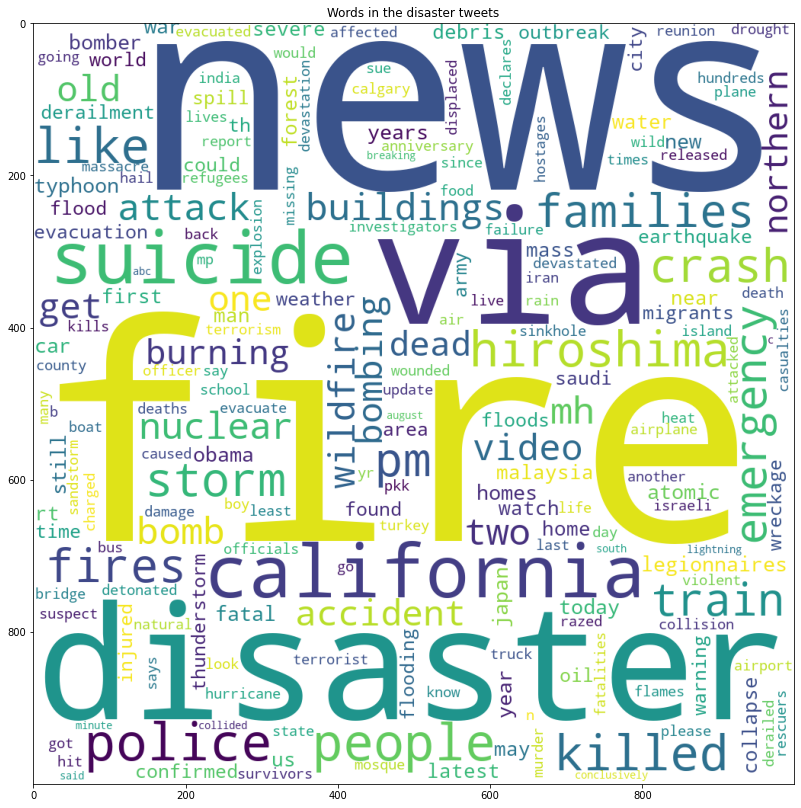

In [11]:
tokenize_flatten = lambda series: (
    list(itertools.chain(*[x.split() for x in series]))
)

wc_size = (14, 14)

tdf = df_train[df_train[target]==1]

unique_words, word_counts = (
    np.unique(tokenize_flatten(tdf[text]), return_counts=True)
)
sm = np.sum(word_counts)
frequency_dict = {
    x: word_counts[i]/sm 
        for i, x in np.ndenumerate(unique_words)
}
try:
    frequency_dict.pop(NUM)
    frequency_dict.pop(AT)
    frequency_dict.pop(http)
    frequency_dict.pop(html)
except:
    log.error("...")
try:
    frequency_dict.pop(UNK)
except:
    log.error("...")

wc = wordcloud.WordCloud(
    width=1000, height=1000, 
    background_color='white',
    min_font_size=10
).generate_from_frequencies(frequency_dict)
fig = plt.figure(figsize=wc_size, facecolor=None)
ax = fig.add_subplot()
ax.set_title("Words in the disaster tweets")
_ = ax.imshow(wc) 

2020-11-12 22:43:28,115 - __main__ - ERROR - ...


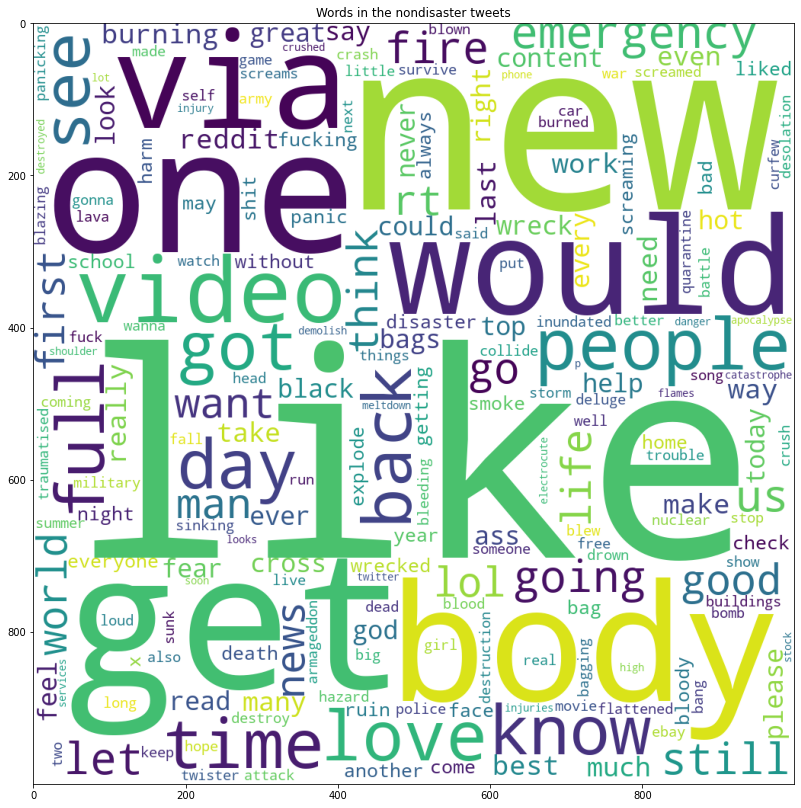

In [12]:
tdf = df_train[df_train[target]==0]
unique_words, word_counts = (
    np.unique(tokenize_flatten(tdf[text]), return_counts=True)
)
sm = np.sum(word_counts)
frequency_dict = {
    x: word_counts[i]/sm
    for i, x in np.ndenumerate(unique_words)
}
try:
    frequency_dict.pop(NUM)
    frequency_dict.pop(AT)
    frequency_dict.pop(http)
    frequency_dict.pop(html)
except:
    log.error("Key not found.")
try:
    frequency_dict.pop(UNK)
except:
    log.error("...")

wc = wordcloud.WordCloud(
    width=1000, height=1000, 
    background_color='white',
    min_font_size=10
).generate_from_frequencies(frequency_dict)
fig = plt.figure(figsize=wc_size, facecolor=None) 
ax = fig.add_subplot()
ax.set_title("Words in the nondisaster tweets")
_ = ax.imshow(wc) 

## Bigrams

We can evaluate the tweets to see what phrases appear more frequently in the two classes
by calculating frequency of sequential pairs of words or bigrams.

In [13]:
def bigrams_count(df, col, top_n=10):
    """
    Count top ${top_n} bigrams in ${df} under column ${col}.
    
    Args:
        df (pandas.DataFrame): Dataframe with text data.
        col (str): Column of ${df}'s text data.
        top_n (int): How many of the most frequent bigrams to return.
        
    Returns:
        (numpy.ndarray): Array of shape (2, N) where first row
            is the unique bigrams and second row is the number of counts
            for each bigram.
    """
    words = [x.split() for x in df[col]]
    bigrams = [x[i]+"_"+x[i+1] for x in words for i in range(len(x)-1)]
    
    uniq_pairs, counts = np.unique(np.array(bigrams), return_counts=True)
        
    return np.array([uniq_pairs, counts])

In [14]:
df_bi_0 = pd.DataFrame(
    bigrams_count(df_train[df_train[target]==0], text).T, 
    columns=["bigram", "count"]
)
df_bi_1 = pd.DataFrame(
    bigrams_count(df_test[df_train[target]==0], text).T, 
    columns=["bigram", "count"]
)

df_bi = df_bi_0.merge(df_bi_1, how="outer", left_on="bigram", 
                      suffixes=("_0", "_1"), right_on="bigram")
df_bi.fillna(0, inplace=True)
df_bi = df_bi.astype({"count_0": int, "count_1": int})
df_bi["total"] = df_bi["count_0"] + df_bi["count_1"]

In [15]:
top_n = 100
top_bigrams = df_bi.nlargest(top_n, "total")

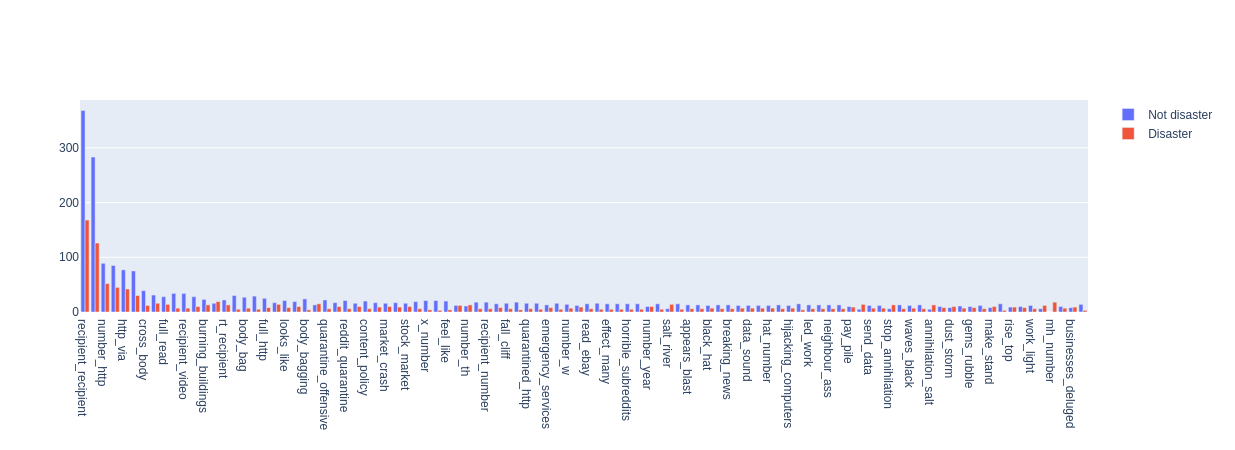

In [16]:
fig = go.Figure()
bar0 = go.Bar(name="Not disaster", 
              x=top_bigrams["bigram"], 
              y=top_bigrams["count_0"]
)
bar1 = go.Bar(name="Disaster",
              x=top_bigrams["bigram"],
              y=top_bigrams["count_1"]
)

fig.add_trace(bar0)
fig.add_trace(bar1)

fig.update_layout(barmode='group')

plotly.offline.iplot(fig)

Notice the confusion with "cross_body" and "body_bag" which clearly 
come from tweets advertising purses, cross-body bags, and are flagged
as possible disaster tweets as a result.

The non-disaster tweets have some distinct tendencies:
mentioning like/liking, more at's, more links.

## Tokenization

For each of our models we have different methods for tokenization.
The BERT model has its own tokenizer. We also try the TensorFlow
text tokenizer which takesn to *top_n* words seen in sample,
and we also try coding our own in Python.

In [17]:
def tokenize_dataframe(df, col, max_len=20):
    """
    Tokenizes text data under column ${col} in dataframe ${df}.
    For model input requirements, we fix the length of the tokenized
    sequence via ${max_len}. If the tokenized sequence is longer
    than ${max_len}, it is front truncated. If the tokenized sequence
    is shorter than ${max_len}, the output is empty string front padded.
    
    Args:
        df (pandas.DataFrame): A dataframe to be altered.
        col (str): Column in ${df} to be tokenized.
        max_len (int): Fixed length of tokenized sequences.
        
    Return:
        enum_cols (list(str)): Names of new columns storing tokenized data.
    """
    df_tmp = pd.DataFrame(
        df[col].apply(lambda x: reversed(x.split())).tolist()
    )
    orig_len = len(df_tmp.columns)
    df_tmp = df_tmp.rename(
        lambda x: col+"_{:02d}".format(max_len-1-x), 
        axis=1
    )
    
    enum_cols = [col+"_{:02d}".format(i) for i in range(max_len)]
    if orig_len < max_len:
        compl_cols = [x for x in enum_cols if x not in df_tmp.columns]
        df_tmp[compl_cols] = np.nan
    
    df[enum_cols] = df_tmp[enum_cols]
    
    return enum_cols


def filter_infrequent(df, cols, cutoff=5):
    """
    Replace words appearing less times than ${cutoff} with ${UNK}.
    
    Args:
        df (pandas.DataFrame): Dataframe to be transformed.
        cols (list(str)): Columns containing token data.
        cutoff (int): Cutoff for rare words.
    
    Return:
        (int): Success.
    """
    unique_words, word_counts = (
        np.unique(df[cols].values.flatten(), return_counts=True)
    )
    infreq_dict = {
        x: (x if word_counts[i] >= cutoff else UNK)
            for i, x in np.ndenumerate(unique_words)
    }

    f = lambda x: infreq_dict[x]
    df[cols] = df[cols].applymap(f)
    
    return SUCCESS


def transform_data(df, col=text):
    """
    Calls ${tokenize_dataframe} and ${filter_infrequent} on ${df}
    along ${col}. Stemming and lemmatization are applied as well
    to the dataframe, and then encoding is applied.
    
    Args:
        df (pandas.DataFrame): Dataframe to be transformed.
        col (str): Column in ${df} containing data to be tokenized.
        
    Returns:
        word_enc (sklearn.preprocessing.LabelEncoder): Encoder
            object built during tokenization.
        num_unique_words (int): Number of unique classes in the encoder.
        word_cols (list(str)): New columns containing tokenized data.
    """
    word_cols = tokenize_dataframe(df, col, max_len=25)
    
    df[word_cols] = df[word_cols].fillna('')
    
    lemmatizer = nltk.stem.WordNetLemmatizer() 
    ps = nltk.stem.PorterStemmer()

    df[word_cols] = df[word_cols].applymap(lambda x: ps.stem(x))
    df[word_cols] = df[word_cols].applymap(lambda x: lemmatizer.lemmatize(x))

    _ = filter_infrequent(df, word_cols, cutoff=10)
        
    word_enc = sklearn.preprocessing.LabelEncoder()
    df[word_cols] = (word_enc
        .fit_transform(df[word_cols].values.flatten())
        .reshape(df[word_cols].shape)
    )

    num_unique_words = word_enc.classes_.shape[0]
    
    return word_enc, num_unique_words, word_cols

In [18]:
def bert_tokenize(df, col):
    """
    Perform preprocessing required for the BERT model.
    
    Args:
        df (pandas.DataFrame): Dataframe to be transformed.
        col (str): Column in ${df} to be transformed.
        
    Returns:
        tokenizer (bert.tokenization.FullTokenizer): BERT tokenizer
            downloaded and fit to the dataframe.
        num_unique_words (int): Number of unique words -- fixed for
            BERT tokenizer.
        word_cols (list(str)): Columns for encoded words in ${df}.
        mask_cols (list(str)): Columns for word masking in ${df}.
        type_cols (list(str)): Columns for word type in ${df}.
    """
    gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"

    tf.io.gfile.listdir(gs_folder_bert)

    tokenizer = bert.tokenization.FullTokenizer(
        vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
        do_lower_case=True
    )

    bert_token = (lambda x: tokenizer
        .convert_tokens_to_ids(['[CLS]'] + tokenizer.tokenize(x) + ['[SEP]'])
    )
    
    num_unique_words = len(tokenizer.vocab)

    pre_words_ids = df[col].apply(bert_token)
    pre_masks = df[col].apply(lambda x: [1]*(len(tokenizer.tokenize(x))+2))

    words_ids = tf.keras.preprocessing.sequence.pad_sequences(pre_words_ids)
    masks = tf.keras.preprocessing.sequence.pad_sequences(pre_masks)
    type_ids = np.zeros(words_ids.shape, dtype=np.int)

    word_cols = [text+"_{:02d}".format(i) for i in range(words_ids.shape[1])]
    mask_cols = ["mask"+"_{:02d}".format(i) 
                 for i in range(words_ids.shape[1])]
    type_cols = ["type"+"_{:02d}".format(i) 
                 for i in range(words_ids.shape[1])]

    df[word_cols] = words_ids
    df[mask_cols] = masks
    df[type_cols] = type_ids
    
    return tokenizer, num_unique_words, word_cols, mask_cols, type_cols

In [19]:
def tf_tokenizer(df, col, num_words):
    """
    Tokenize text column ${col} in dataframe ${df} using
    tensorflow.keras.preprocessing.text.Tokenizer taken
    ${num_words} number of words.
    
    Args:
        df (pandas.DataFrame): Dataframe to be transformed.
        col (str): Column of text data in ${df}.
        num_words (int): Number of words to take in enumerated alphabet.
        
    Returns:
        tokenizer (tensorflow.keras.preprocessing.text.Tokenizer):
            Tokenizer fit to the data.
        num_words (int): Number of words in the tokenized alphabet.
        word_cols (list(str)): New columns of tokenized data.
    """
    tokenizer = (
        tf.keras.preprocessing.text.Tokenizer(num_words=num_words)
    )
    tokenizer.fit_on_texts(df[col].values)
    word_ar = tf.keras.preprocessing.sequence.pad_sequences(
        tokenizer.texts_to_sequences(df[col].values)
    )
    word_cols = ["text_{:02d}".format(i) for i in range(word_ar.shape[1])]
    df[word_cols] = word_ar
    
    return tokenizer, num_words, word_cols

In [20]:
df_full = pd.concat([df_train, df_test], ignore_index=True)

#word_enc, num_unique_words, word_cols = transform_data(df_full)
tokenizer, num_unique_words, word_cols = tf_tokenizer(df_full, text, 1000)
#tokenizer, num_unique_words, word_cols, mask_cols, type_cols = bert_tokenize(df_full, text)

log.info(f"Vocab size: {num_unique_words}")

2020-11-12 22:43:31,018 - __main__ - INFO - Vocab size: 1000


In [21]:
df_full.head(10)

,id,keyword,location,text,target,t,hashtag,at,href,text_00,text_01,text_02,text_03,text_04,text_05,text_06,text_07,text_08,text_09,text_10,text_11,text_12,text_13,text_14,text_15,text_16,text_17,text_18,text_19
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,deeds reason earthquake may allah forgive us,#earthquake,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,693,144,66,20
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,forest fire near la ronge sask canada,,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,83,6,112,735
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0,residents asked shelter place notified officers evacuation shelter place orders expected,,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,600,167,600
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1.0,number people receive wildfires evacuation orders california,#wildfires,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,11,167,32
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0,got sent photo ruby alaska smoke wildfires pours school,#alaska #wildfires,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,187,176,108
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1.0,rockyfire update california hwy number closed directions due lake county fire cafire wildfires,#rockyfire #cafire #wildfires,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,286,32,3,736,299,300,6
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1.0,flood disaster heavy rain causes flash flooding streets manitou colorado springs areas,#flood #disaster,,0,0,0,0,0,0,0,0,0,0,0,0,0,109,15,767,197,948,737,198,949
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1.0,top hill see fire woods,,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,116,38,6
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1.0,emergency evacuation happening building across street,,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,167,459,738,540
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1.0,afraid tornado coming area,,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,475,150,208


In [22]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"
bert_layer = hub.KerasLayer(hub_url_bert, trainable=True)

In [23]:
class TwolayerModel(tf.keras.Model):
    """
    """
    def __init__(self,
        batch_size=32,
        units=40,
        embed_dim=100,
        sequence_length=len(word_cols),
    ):
        """
        """
        super(TwolayerModel, self).__init__()

        self.inps = (None, sequence_length)
        self.bs = batch_size
        out_dim = 2        
        
        self._embed1 = tf.keras.layers.Embedding(
            num_unique_words,
            embed_dim,
            input_length=self.inps[1],
            name="word_embedding",
        )
        self._lstm1 = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                units,
                name="lstm1",
                return_sequences=True,
            )
        )
        
        self._lstm2 = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                units,
                name="lstm2",
            )
        )

        self._dense2 = tf.keras.layers.Dense(
            out_dim,
            activation=tf.nn.softmax,
            name="final",
        )
        
        self._optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        self._metrics = [tf.keras.metrics.BinaryAccuracy()]
        self._loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        #self._loss = tf.keras.losses.KLDivergence()
        
        self.compile(
            optimizer=self._optimizer,
            loss=self._loss,
            metrics=self._metrics,
        )

        self.build(self.inps)
        

    def call(self, inputs):        
        x1 = self._embed1(inputs)
        y1 = self._lstm1(x1)
        y1 = self._lstm2(y1)
        out = self._dense2(y1)
        
        return out

In [24]:
class OnelayerModel(tf.keras.Model):
    """
    """
    def __init__(self,
            batch_size=32,
            units=40,
            embed_dim=100,
            sequence_length=len(word_cols),
    ):
        """
        """
        super(OnelayerModel, self).__init__()

        self.inps = [
            (None, sequence_length),
            (None, sequence_length),
            (None, sequence_length),
        ]
        self.bs = batch_size
        out_dim = 2
              
        self._embed1 = tf.keras.layers.Embedding(
            num_unique_words,
            embed_dim,
            input_length=self.inps[0][1],
            name="word_embedding",
        )
        self._lstm1 = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                units,
                name="lstm1",
            )
        )
        
        self._dense2 = tf.keras.layers.Dense(
            out_dim,
            activation=tf.nn.softmax,
            name="final",
        )
        
        self._optimizer = tf.keras.optimizers.Adam(
                            learning_rate=0.0001
        )
        self._metrics = [tf.keras.metrics.BinaryAccuracy()]
        self._loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        #self._loss = tf.keras.losses.KLDivergence()
        
        self.compile(
            optimizer=self._optimizer,
            loss=self._loss,
            metrics=self._metrics,
        )

        self.build(self.inps[0])
        

    def call(self, inputs):        
        x1 = self._embed1(inputs)
        y1 = self._lstm1(x1)
        out = self._dense2(y1)
        
        return out

In [25]:
class ConvModel(tf.keras.Model):
    """
    """
    def __init__(self,
            batch_size=32,
            units=40,
            embed_dim=100,
            sequence_length=len(word_cols),
    ):
        """
        """
        self.inps = (None, sequence_length)
        self.bs = batch_size
        out_dim = 2
        
        super(ConvModel, self).__init__()
        
        self._embed1 = tf.keras.layers.Embedding(
            num_unique_words,
            embed_dim,
            input_length=self.inps[1],
            name="word_embedding",
        )
            
        filters = 100
        window = 5
        
        self._conv1 = tf.keras.layers.Conv1D(
            filters,
            window
        )
        
        self._flatten = tf.keras.layers.Flatten()
        
        self._dense1 = tf.keras.layers.Dense(
            units,
            activation=tf.nn.relu,
            name="dense",
        )
        
        self._dense2 = tf.keras.layers.Dense(
            out_dim,
            activation=tf.nn.softmax,
            name="final",
        )
        
        self._optimizer = tf.keras.optimizers.Adam(
                            learning_rate=0.0001
        )
        self._metrics = [tf.keras.metrics.BinaryAccuracy()]
        self._loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        #self._loss = tf.keras.losses.KLDivergence()
        
        self.compile(
            optimizer=self._optimizer,
            loss=self._loss,
            metrics=self._metrics,
        )

        self.build(self.inps)
        

    def call(self, inputs):
        x1 = self._embed1(inputs)
        x1 = self._conv1(x1)
        y1 = self._flatten(x1)
        z = self._dense1(y1)
        out = self._dense2(z)
        
        return out

In [26]:
class BERTModel(tf.keras.Model):
    """
    """
    def __init__(self,
            batch_size=64,
            units=40,
            embed_dim=100,
            sequence_length=len(word_cols),
    ):
        """
        """
        super(BERTModel, self).__init__()

        self.inps = [
            (None, sequence_length),
            (None, sequence_length),
            (None, sequence_length),
        ]
        self.bs = batch_size
        out_dim = 2
        
        self.max_seq_length = sequence_length
        self.bert_layer = bert_layer
        
        self.input_word_ids = tf.keras.Input(
            shape=(self.max_seq_length,), 
            dtype=tf.int32, 
            name='input_word_ids'
        )
        self.input_m = tf.keras.Input(
            shape=(self.max_seq_length,), 
            dtype=tf.int32, 
            name='input_mask'
        )
        self.segment_ids = tf.keras.Input(
            shape=(self.max_seq_length,), 
            dtype=tf.int32, 
            name='segment_ids'
        )  
        
        self._dense0 = tf.keras.layers.Dense(units, activation=tf.nn.relu)
        self._do0 = tf.keras.layers.Dropout(0.5)
        
        self._dense2 = tf.keras.layers.Dense(
            out_dim,
            activation=tf.nn.softmax,
            name="final",
        )
        
        self._optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
        self._metrics = [tf.keras.metrics.BinaryAccuracy()]
        self._loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        #self._loss = tf.keras.losses.KLDivergence()
        
        self.compile(
            optimizer=self._optimizer,
            loss=self._loss,
            metrics=self._metrics,
        )

        self.inputs = (self.input_word_ids, self.input_m, self.segment_ids)
        self.outputs = self._dense2
        
        
    def call(self, inputs, training=False):        
        self.input_word_ids, self.input_m, self.segment_ids = inputs
        pooled_output, sequence_output = self.bert_layer(
            [
                self.input_word_ids,
                self.input_m,
                self.segment_ids
            ]
        )   
        clf_output = sequence_output[:, 0, :]
        z = self._dense0(clf_output)
        if training:
            z = self._do0(z, training=training)
        out = self._dense2(z)
        
        return out

In [27]:
tfboard_dir = "logs"
if not os.path.exists(tfboard_dir):
    os.mkdir(tfboard_dir)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tfboard_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_binary_accuracy",
    min_delta=1e-5,
    patience=10,
    baseline=0.5,
    restore_best_weights=True,
)

## Non-BERT models and dataset preparation

The BERT model has a different input shape, so we need to split
up the dataset preparation code. Do not run this code block or
comment out if using the BERT model.

In [28]:
model = TwolayerModel(batch_size=32, units=20, embed_dim=200)
#model = ConvModel(batch_size=512, units=30, embed_dim=200)
#model = OnelayerModel(batch_size=256, units=50, embed_dim=200)

df_test = df_full.iloc[train_pts:]
df_train = df_full.iloc[:train_pts]

log.info(f"Dataset size: {df_train.shape[0]}")

remainder = df_train.shape[0] % model.bs
pad_size = model.bs - remainder if remainder !=0 else 0
log.info(f"Remainder from batch size: {remainder}\n"
         f"Padding {pad_size} elements."
)

X1 = df_train[word_cols].values.astype(int)

X_unpad = tf.convert_to_tensor(X1, dtype=tf.int32, name='input_word_ids')

if pad_size > 0:
    X1 = np.vstack([X1, np.zeros((pad_size, X1.shape[1])).astype(int)])

X1 = tf.convert_to_tensor(X1, dtype=tf.int32, name='input_word_ids')

df_train[y_cols] = pd.get_dummies(df_train[target], prefix=target)
Y = df_train[y_cols].values
Y_add = np.zeros((pad_size, 2))
Y_add[:, 0] = 1.0
if pad_size > 0:
    Y = np.vstack([Y, Y_add])

X_val = (X1)

X = (
    tf.data.Dataset.from_tensor_slices((X_val, Y))
        .batch(model.bs, drop_remainder=True)
)

X = X.shuffle(buffer_size=10000)

q = 5
p = 1

select = lambda x, y: (x % q <= p)
nselect = lambda x, y: ~(x % q <= p)
take = lambda x, y: y

X_train = X.enumerate().filter(nselect).map(take)
X_valid = X.enumerate().filter(select).map(take)

log.info(f"Test dataset size: {df_test.shape}")

Z1 = df_test[word_cols].values.astype(int)
Z1 = tf.convert_to_tensor(Z1, dtype=tf.int32, name='input_word_ids')

X_test = Z1

2020-11-12 22:43:34,814 - __main__ - INFO - Dataset size: 7613
INFO:__main__:Dataset size: 7613
2020-11-12 22:43:34,815 - __main__ - INFO - Remainder from batch size: 29
Padding 3 elements.
INFO:__main__:Remainder from batch size: 29
Padding 3 elements.
2020-11-12 22:43:34,877 - __main__ - INFO - Test dataset size: (3263, 29)
INFO:__main__:Test dataset size: (3263, 29)


## BERT model and dataset preparation

The BERT model has a different input shape, this code is a variation
on the previous  dataset preparation code. Do not run this code block or
comment out if not using the BERT model.

model = BERTModel(batch_size=32)

df_test = df_full.iloc[train_pts:]
df_train = df_full.iloc[:train_pts]

log.info(f"Dataset size: {df_train.shape[0]}")

remainder = df_train.shape[0] % model.bs
pad_size = model.bs - remainder if remainder !=0 else 0
log.info(f"Remainder from batch size: {remainder}\n"
         f"Padding {pad_size} elements."
)

X1 = df_train[word_cols].values.astype(int)
X2 = df_train[mask_cols].values.astype(int)
X3 = df_train[type_cols].values.astype(int)

X_unpad = (
    tf.convert_to_tensor(X1, dtype=tf.dtypes.int32, name='input_word_ids'),
    tf.convert_to_tensor(X2, dtype=tf.dtypes.int32, name='input_mask'),
    tf.convert_to_tensor(X3, dtype=tf.dtypes.int32, name='input_type_ids'),
)

if pad_size > 0:
    X1 = np.vstack([X1, np.zeros((pad_size, X1.shape[1])).astype(int)])
    X2 = np.vstack([X2, np.zeros((pad_size, X1.shape[1])).astype(int)])
    X3 = np.vstack([X3, np.zeros((pad_size, X1.shape[1])).astype(int)])

X1 = tf.convert_to_tensor(X1, dtype=tf.dtypes.int32, name='input_word_ids')
X2 = tf.convert_to_tensor(X2, dtype=tf.dtypes.int32, name='input_mask')
X3 = tf.convert_to_tensor(X3, dtype=tf.dtypes.int32, name='input_type_ids')

df_train[y_cols] = pd.get_dummies(df_train[target], prefix=target)
Y = df_train[y_cols].values
Y_add = np.zeros((pad_size, 2))
Y_add[:, 0] = 1.0
if pad_size > 0:
    Y = np.vstack([Y, Y_add])

X_val = (X1, X2, X3)

X = (
    tf.data.Dataset.from_tensor_slices((X_val, Y))
        .batch(model.bs, drop_remainder=True)
)

X = X.shuffle(buffer_size=10000)

q = 5
p = 1

select = lambda x, y: (x % q <= p)
nselect = lambda x, y: ~(x % q <= p)
take = lambda x, y: y

X_train = X.enumerate().filter(nselect).map(take)
X_valid = X.enumerate().filter(select).map(take)

log.info(f"Test dataset size: {df_test.shape}")

Z1 = df_test[word_cols].values.astype(int)
Z2 = df_test[mask_cols].values.astype(int)
Z3 = df_test[type_cols].values.astype(int)

Z1 = tf.convert_to_tensor(Z1, dtype=tf.int32, name='input_word_ids')
Z2 = tf.convert_to_tensor(Z2, dtype=tf.int32, name='input_mask')
Z3 = tf.convert_to_tensor(Z3, dtype=tf.int32, name='input_type_ids')

X_test = (Z1, Z2, Z3)

In [29]:
hist = model.fit(
    X_train, 
    epochs=8,
    validation_data=X_valid,
    callbacks=[
        #tensorboard_callback, 
        early_stopping
    ],
)

Epoch 1/8
142/142 [==============================] - 2s 15ms/step - loss: 0.6816 - binary_accuracy: 0.5632 - val_loss: 0.6666 - val_binary_accuracy: 0.5811
Epoch 2/8
142/142 [==============================] - 2s 11ms/step - loss: 0.6580 - binary_accuracy: 0.5882 - val_loss: 0.6303 - val_binary_accuracy: 0.6592
Epoch 3/8
142/142 [==============================] - 2s 11ms/step - loss: 0.6173 - binary_accuracy: 0.6567 - val_loss: 0.5849 - val_binary_accuracy: 0.7165
Epoch 4/8
142/142 [==============================] - 2s 11ms/step - loss: 0.5707 - binary_accuracy: 0.7212 - val_loss: 0.5412 - val_binary_accuracy: 0.7321
Epoch 5/8
142/142 [==============================] - 2s 11ms/step - loss: 0.5138 - binary_accuracy: 0.7586 - val_loss: 0.4751 - val_binary_accuracy: 0.7816
Epoch 6/8
142/142 [==============================] - 2s 11ms/step - loss: 0.4690 - binary_accuracy: 0.7850 - val_loss: 0.4322 - val_binary_accuracy: 0.8053
Epoch 7/8
142/142 [==============================] - 2s 11ms/ste

In [30]:
model.summary()

Model: "twolayer_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding (Embedding)   multiple                  200000    
_________________________________________________________________
bidirectional (Bidirectional multiple                  26640     
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  7440      
_________________________________________________________________
final (Dense)                multiple                  82        
_________________________________________________________________
binary_accuracy (BinaryAccur multiple                  2         
Total params: 234,164
Trainable params: 234,162
Non-trainable params: 2
_________________________________________________________________


In [31]:
Y_train_pred = model.predict(X_unpad)
Y_test_pred = model.predict(X_test)

In [32]:
df_train_pred = pd.DataFrame(Y_train_pred, columns=y_cols)
df_train_pred = df_train_pred.apply(np.round).astype({x: int for x in y_cols})
df_train_pred[target] = df_train_pred["target_1"]
df_train_pred.drop(y_cols, inplace=True, axis=1)
df_train_pred["id"] = df_train["id"].values
df_train_pred = df_train_pred[["id", target]]

In [33]:
df_test_pred = pd.DataFrame(Y_test_pred, columns=y_cols)
df_test_pred = df_test_pred.apply(np.round).astype({x: int for x in y_cols})
df_test_pred[target] = df_test_pred["target_1"]
df_test_pred.drop(y_cols, inplace=True, axis=1)
df_test_pred.drop(list(df_test_pred.index[df_train.shape[0]:]), inplace=True, axis=0)
df_test_pred["id"] = df_test["id"].values
df_test_pred = df_test_pred[["id", target]]

In [34]:
log.info("\n" +
    sklearn.metrics.classification_report(
        df_train[target],
        df_train_pred[target],
        target_names=["Not disaster", "Disaster"]
    )
)

2020-11-12 22:43:52,374 - __main__ - INFO - 
              precision    recall  f1-score   support

Not disaster       0.82      0.90      0.86      4342
    Disaster       0.84      0.74      0.79      3271

    accuracy                           0.83      7613
   macro avg       0.83      0.82      0.82      7613
weighted avg       0.83      0.83      0.83      7613

INFO:__main__:
              precision    recall  f1-score   support

Not disaster       0.82      0.90      0.86      4342
    Disaster       0.84      0.74      0.79      3271

    accuracy                           0.83      7613
   macro avg       0.83      0.82      0.82      7613
weighted avg       0.83      0.83      0.83      7613



In [35]:
log.info("Training accuracy score {}.".format(
    sklearn.metrics.accuracy_score(df_train[target], df_train_pred[target])
    )
)

2020-11-12 22:43:52,392 - __main__ - INFO - Training accuracy score 0.8291081045579929.
INFO:__main__:Training accuracy score 0.8291081045579929.


In [36]:
#model.save(os.path.join(tfboard_dir, "model"))
#df_test_pred.to_csv(os.path.join(data_dir, "results.csv"), index=False)

%load_ext tensorboard

%tensorboard --logdir logs